In [13]:
import pandas as pd
import numpy as np
import os
import sys
import json
from pathlib import Path

BASE_DIR = Path.cwd().parent.parent
DATA_DIR = os.path.join(BASE_DIR, "data", "data_final")
CSV_PATH = os.path.join(BASE_DIR, "data", "data_final", "final_dataset.csv")
NOVELTY_PATH = os.path.join(DATA_DIR, "knn_faiss_novelty.csv")

sys.path.insert(0, str(BASE_DIR))

from src.data_utils import load_final_data_with_embeddings

In [7]:
df = load_final_data_with_embeddings(CSV_PATH, DATA_DIR)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92374 entries, 0 to 92373
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   movie_id                       92374 non-null  object 
 1   country                        91534 non-null  object 
 2   imdb_id                        91006 non-null  object 
 3   duration                       57734 non-null  float64
 4   duration_all                   57734 non-null  object 
 5   actors_id                      75496 non-null  object 
 6   actors                         75496 non-null  object 
 7   directors_id                   86598 non-null  object 
 8   directors                      86598 non-null  object 
 9   genre_id                       80918 non-null  object 
 10  genre                          80884 non-null  object 
 11  release_date                   92374 non-null  object 
 12  wikidata_class                 92374 non-null 

In [16]:
knn_results = pd.read_csv(NOVELTY_PATH)
knn_results["neighbor_distances"] = knn_results["neighbor_distances"].apply(lambda x: json.loads(x))
knn_results["novelty_score"] = knn_results["neighbor_distances"].apply(lambda x: x[0])
print(knn_results.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92374 entries, 0 to 92373
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_id            92374 non-null  object 
 1   neighbor_ids        92374 non-null  object 
 2   neighbor_distances  92374 non-null  object 
 3   novelty_score       92374 non-null  float64
dtypes: float64(1), object(3)
memory usage: 2.8+ MB
None


In [17]:
knn_results["novelty_score"].describe()

count    92374.000000
mean         0.295068
std          0.098861
min         -1.000000
25%          0.273120
50%          0.302031
75%          0.330129
max          0.531699
Name: novelty_score, dtype: float64

In [29]:
knn_results[knn_results["movie_id"] == "Q19089"]

,movie_id,neighbor_ids,neighbor_distances,novelty_score
43372,Q19089,"['Q320423', 'Q332368', 'Q106440', 'Q107914', '...","[0.20699334144592285, 0.23593145608901978, 0.2...",0.206993


In [18]:
df_merged = df.merge(knn_results[["movie_id", "novelty_score"]], on="movie_id", how="left")
print(df_merged.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92374 entries, 0 to 92373
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   movie_id                       92374 non-null  object 
 1   country                        91534 non-null  object 
 2   imdb_id                        91006 non-null  object 
 3   duration                       57734 non-null  float64
 4   duration_all                   57734 non-null  object 
 5   actors_id                      75496 non-null  object 
 6   actors                         75496 non-null  object 
 7   directors_id                   86598 non-null  object 
 8   directors                      86598 non-null  object 
 9   genre_id                       80918 non-null  object 
 10  genre                          80884 non-null  object 
 11  release_date                   92374 non-null  object 
 12  wikidata_class                 92374 non-null 

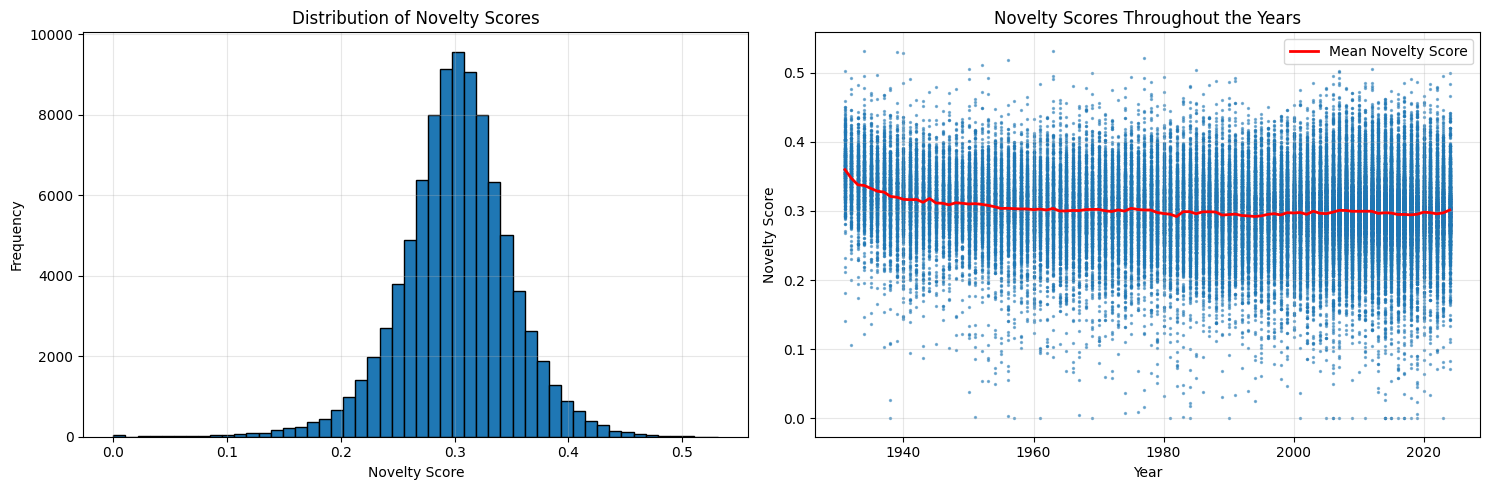

In [21]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Distribution of novelty scores
axes[0].hist(df_merged[df_merged['novelty_score'] > 0]['novelty_score'], bins=50, edgecolor='black')
axes[0].set_xlabel('Novelty Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Novelty Scores')
axes[0].grid(True, alpha=0.3)

# Plot 2: Novelty scores throughout the years
valid_data = df_merged[df_merged['novelty_score'] >= 0]
axes[1].scatter(valid_data['year'], valid_data['novelty_score'], alpha=0.5, s=2)
year_means = valid_data.groupby('year')['novelty_score'].mean()
axes[1].plot(year_means.index, year_means.values, color='red', linewidth=2, label='Mean Novelty Score')
axes[1].legend()
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Novelty Score')
axes[1].set_title('Novelty Scores Throughout the Years')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [28]:
top_20_novel_movies = df_merged[df_merged['year'] >= 2000].nlargest(20, 'novelty_score')[['movie_id', 'title', 'year', 'novelty_score']]
print(top_20_novel_movies)

         movie_id                                              title  year  \
69710    Q4895390                                    Bert and Dickie  2012   
60038    Q7622483       Strawberry Shortcake: Berry Blossom Festival  2007   
59440    Q5438078                                     Fauj Mein Mauj  2007   
91487  Q127709937                                        Diva Futura  2024   
90250  Q121462672                                    The Vaccine War  2023   
58034    Q7622422                                  Strawberry Fields  2006   
60092   Q12128357                  Strawberry Shortcake: Let's Dance  2007   
82174   Q39074033                                           JT LeRoy  2018   
85142   Q64450077                                The Black Godfather  2019   
69209    Q3521550                        The Lebanese Rocket Society  2012   
81606   Q47345385                                             Voyeur  2017   
67100    Q1657033                                    If a Tree F